In [127]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6577967121458069545
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3839370315613132905
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12145478905771211131
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3609809224462089089
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31596239913
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 6917281574613048664
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0"
, name: "/device:GPU:1"
device_type: "GP

In [128]:
import tensorflow as tf
print(tf.test.is_gpu_available())   # 判断GPU是否可用
print(tf.test.is_built_with_cuda()) # 判断CUDA是否可用

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("NAEM:",gpu.name,"TYPE:",gpu.device_type)

True
True
NAEM: /physical_device:GPU:0 TYPE: GPU
NAEM: /physical_device:GPU:1 TYPE: GPU


In [129]:
import numpy as np #維度陣列與矩陣運算
from matplotlib import pyplot as plt #畫圖
%matplotlib inline
import glob # 整合路徑
import tqdm # 進度條
import datetime # 計算時間
import csv # 讀取CSV
import os, shutil # 建立資料夾 
import tensorflow as tf #深度學習框架，用於設定啟用GPU

# image path
img_path = "data/imgbmp"

In [130]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8"   #指定第幾區塊GPU可用  
config = tf.ConfigProto()  
config.gpu_options.per_process_gpu_memory_fraction = 0.8  # 程式最多隻能佔用指定gpu70%的視訊記憶體  
config.gpu_options.allow_growth = True      #程式按需申請記憶體  
sess = tf.Session(config = config)

In [131]:
global one_v_all_label
one_v_all_label = '1'
target = '1' 
matchtarget = '0'

In [132]:
# 判斷是否存在
if not os.path.exists(img_path + '/test'):
    # 建立資料夾
    os.makedirs(img_path + '/test')
else:
    # 清空資料夾內的所有資料
    shutil.rmtree(img_path + '/test')
    # 建立資料夾
    os.makedirs(img_path + '/test')
# 判斷是否存在
if not os.path.exists(img_path + '/train'):
    # 建立資料夾
    os.makedirs(img_path + '/train')
else:
    # 清空資料夾內的所有資料
    shutil.rmtree(img_path + '/train')
    # 建立資料夾
    os.makedirs(img_path + '/train')
# 判斷是否存在
if not os.path.exists(img_path + '/valid'):
    # 建立資料夾
    os.makedirs(img_path + '/valid')
else:
    # 清空資料夾內的所有資料
    shutil.rmtree(img_path + '/valid')
    # 建立資料夾
    os.makedirs(img_path + '/valid')

In [133]:
def create_label_directories(csv_filename, target, matchtarget, img_path, is_one_v_all=False):
    all_labels = set() 
    # 開啟CSV
    with open(csv_filename, 'r') as csvfile:
        # 讀取CSV delimiter切割方式
        reader = csv.reader(csvfile, delimiter=',')
        next(csvfile) # skip header row
        for row in reader:
            # 檔案名稱
            img_filename = str(row[0])
            # 類別
            labels = str(row[1])
            # split='|'切分類別
            for label in labels.split('|'):
                # 判斷不為二元模型、target、matchtarget
                if (is_one_v_all is True) and (label != target) and (label != matchtarget):
                    # 跳過->for
                    continue
                # 影像路徑
                src_file = os.path.join(img_path,img_filename)
                # 有空白的部分以_取代
                label = "_".join(label.split())
                # 訓練集資料夾路徑
                dst_train_dir = os.path.join(img_path,"train",label)
                # 影像放置到訓練集資料夾的路徑
                dst_train_file = os.path.join(dst_train_dir,img_filename)
                # 驗證集資料夾路徑
                dst_valid_dir = os.path.join(img_path,"valid",label)
                # 測試集資料夾路徑
                dst_test_dir = os.path.join(img_path,"test",label)
                # 判斷有沒有資料夾
                if not os.path.exists(dst_train_dir):
                    # 建立資料夾
                    os.makedirs(dst_train_dir)
                    all_labels.add(label)
                if not os.path.exists(dst_valid_dir):
                    os.makedirs(dst_valid_dir)
                if not os.path.exists(dst_test_dir):
                    os.makedirs(dst_test_dir)
                # 原始影像路徑
                src_file_abs = os.path.join(os.getcwd(),src_file)
                # 新的影像路徑
                dst_train_file_abs = os.path.join(os.getcwd(),dst_train_file)
                #print("copy: " + src_file_abs + " to: " + dst_train_file_abs)
                # 將符合條件的影像以連結(捷徑)的方式複製到訓練集的資料夾裡
                if not os.path.exists(dst_train_file_abs):
                    shutil.copyfile(src_file_abs,dst_train_file_abs)
                
    return list(all_labels)
# 設定是不是為二元模型
is_one_v_all = True
print(img_path)
all_labels = create_label_directories("data/csvdatabmp.csv", target, matchtarget, img_path, is_one_v_all)
print(all_labels)

data/imgbmp
['1', '0']


In [134]:
# 類別陣列[類別一(比對目標),類別二(訓練目標)]，確保類別陣列[1]為訓練目標
print(all_labels)
all_label=[]
if(all_labels[0]==one_v_all_label):
    all_label.append(all_labels[1])
    all_label.append(all_labels[0])
else:
    all_label=all_labels
all_labels=all_label
print(all_labels)

['1', '0']
['0', '1']


In [135]:
# 計算總影像數量
def get_per_label_count(all_labels):
    per_label_count = []
    for ii in range(len(all_labels)):
        #print(directories[ii])
        # os.walkc取得路徑、資料夾、檔案名稱
        path, dirs, files = os.walk(os.path.join(img_path,"train",all_labels[ii])).__next__()
        # 取得檔案數量
#         print(files)
        file_count = len(files)
        per_label_count.append(file_count)
    return per_label_count
        
print(all_labels)
per_label_count = get_per_label_count(all_labels) 
print(per_label_count)

['0', '1']
[6242, 811]


In [136]:
# 下採樣
def downsample(all_labels, per_label_count):
    # 以數量最少的類別為基準值
    label_idx = np.argmin(per_label_count)
    # 需要下採樣的類別影像數量
    downsample_count = per_label_count[label_idx]
    print('downsample_count',downsample_count)
    #print(downsample_count)
    for ii in tqdm.tqdm(range(len(per_label_count))):
        label = all_labels[ii]
        # 資料夾路徑
        src_train_dir = os.path.join(img_path,"train",label)
        # 影像檔案路徑
        print(src_train_dir)
        all_img_paths = glob.glob(os.path.join(src_train_dir,"*.*"))
        # 隨機排序
        print(all_img_paths)

        np.random.shuffle(all_img_paths)
        # 判斷數量是否為label_idx
        if len(all_img_paths) != downsample_count:
            imgs_to_remove = all_img_paths[downsample_count:]
            for file in imgs_to_remove:
                # os.path.join整合路徑
                file_abs = os.path.join(os.getcwd(),file)
                # 移除多出來的影像
                os.remove(file_abs)
    return get_per_label_count(all_labels)
                
print(all_labels)
per_label_count_downsampled = downsample(all_labels, per_label_count)
print(per_label_count_downsampled)

  0%|          | 0/2 [00:00<?, ?it/s]

['0', '1']
downsample_count 811
data/imgbmp/train/0
['data/imgbmp/train/0/IMG_86064184_20200817_2_25.bmp', 'data/imgbmp/train/0/IMG_24649703_20190911_2_3.bmp', 'data/imgbmp/train/0/IMG_33911052_20200831_2_4.bmp', 'data/imgbmp/train/0/IMG_9223189_20200803_2_3.bmp', 'data/imgbmp/train/0/IMG_90306554_20200803_2_6.bmp', 'data/imgbmp/train/0/IMG_9855804_20200305_2_4.bmp', 'data/imgbmp/train/0/IMG_62762201_20200205_2_1.bmp', 'data/imgbmp/train/0/IMG_91986021_20200601_2_8.bmp', 'data/imgbmp/train/0/IMG_4781439_20200629_2_3.bmp', 'data/imgbmp/train/0/IMG_94082594_20191009_2_8.bmp', 'data/imgbmp/train/0/IMG_74950101_20171101_2_4.bmp', 'data/imgbmp/train/0/IMG_31763664_20190614_1_5.bmp', 'data/imgbmp/train/0/IMG_2986185_20200303_1_4.bmp', 'data/imgbmp/train/0/IMG_74950101_20171101_2_2.bmp', 'data/imgbmp/train/0/IMG_40762202_20200114_2_3.bmp', 'data/imgbmp/train/0/IMG_2151866_20190326_1_5.bmp', 'data/imgbmp/train/0/IMG_32159521_20190202_2_1.bmp', 'data/imgbmp/train/0/IMG_61455383_20200626_2_2.bmp

100%|██████████| 2/2 [00:15<00:00,  7.79s/it]

data/imgbmp/train/1
['data/imgbmp/train/1/IMG_56590584_20200730_0_5.bmp', 'data/imgbmp/train/1/IMG_71401483_20200417_3_3.bmp', 'data/imgbmp/train/1/IMG_54962434_20200903_0_1.bmp', 'data/imgbmp/train/1/IMG_14800391_20200924_3_10.bmp', 'data/imgbmp/train/1/IMG_95347901_20130618_0_3.bmp', 'data/imgbmp/train/1/IMG_67978001_20150730_0_4.bmp', 'data/imgbmp/train/1/IMG_85457102_20191202_6_9.bmp', 'data/imgbmp/train/1/IMG_96962331_20150316_5_5.bmp', 'data/imgbmp/train/1/IMG_81967352_20200519_4_14.bmp', 'data/imgbmp/train/1/IMG_27022411_20180521_4_13.bmp', 'data/imgbmp/train/1/IMG_72126711_20090306_5_2.bmp', 'data/imgbmp/train/1/IMG_03173331_20150709_5_1.bmp', 'data/imgbmp/train/1/IMG_25760111_20130219_0_2.bmp', 'data/imgbmp/train/1/IMG_86267801_20090720_4_4.bmp', 'data/imgbmp/train/1/IMG_65663594_20200803_4_6.bmp', 'data/imgbmp/train/1/IMG_90357602_20191214_4_9.bmp', 'data/imgbmp/train/1/IMG_975021_20180504_4_6.bmp', 'data/imgbmp/train/1/IMG_10090741_20200113_4_1.bmp', 'data/imgbmp/train/1/IMG

In [137]:
def split_train_valid_test(all_labels, per_label_count, valid_pct, test_pct):
    for ii in range(len(all_labels)):
        # glob取得所有影像路徑
        all_img_paths = glob.glob(os.path.join(img_path,"train",all_labels[ii],"*.*"))
        # 隨機排序
        np.random.shuffle(all_img_paths)
        # 取得影像數量
        label_count = per_label_count[ii]
        # 要移至驗證集的影像數量
        valid_count = int(label_count*valid_pct)
        # 要移至驗證集的影像
        valid_files = all_img_paths[:valid_count]
        # 清空
        all_img_paths[:valid_count] = []
        # 要移至測試集的影像數量
        test_count = int(label_count*test_pct)
        # 要移至測試集的影像
        test_files = all_img_paths[:test_count]
        # 清空
        all_img_paths[:test_count] = []

        all_img_paths = []
        # 將影像移動至驗證集資料夾裡
        for valid_file in valid_files:
            # 影像檔案路徑
            valid_file_abs = os.path.join(os.getcwd(),valid_file)
            # 移動檔案
            shutil.move(valid_file_abs, os.path.join(img_path,"valid",all_labels[ii]))
        # 將影像移動至驗證集資料夾裡
        for test_file in test_files:
            # 影像檔案路徑
            test_file_abs = os.path.join(os.getcwd(),test_file)
            # 移動檔案
            shutil.move(test_file_abs, os.path.join(img_path,"test",all_labels[ii]))

# train=0.7
valid_pct = 0.1 # 0.1
test_pct = 0.2 # 0.1       
print(all_labels)
print(per_label_count_downsampled)
split_train_valid_test(all_labels, per_label_count_downsampled, valid_pct, test_pct)

['0', '1']
[811, 811]


In [138]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input

train_datagen = ImageDataGenerator(
    width_shift_range=0.2, # 隨機水平平移20%
    height_shift_range=0.2, # 隨機垂直平移20%
    rotation_range=2, # 隨機旋轉2%
    zoom_range=0.2, # 隨機放大縮小20%
    horizontal_flip=True, # 隨機水平翻轉
    preprocessing_function=preprocess_input # 歸一化，範圍0-1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # 歸一化，範圍0-1
)

In [152]:
batch_size = 64
img_height = 224 
img_width = 224 
train_generator = train_datagen.flow_from_directory( # 影像處理方式
    'data/imgbmp/train', # 訓練集路徑
    target_size=(img_height, img_width), # 輸入影像大小
    classes=all_labels, # 類別
    batch_size=batch_size) # 批次大小

validation_generator = test_datagen.flow_from_directory( # 影像處理方式
    'data/imgbmp/valid', # 驗證集路徑
    target_size=(img_height, img_width), # 輸入影像大小
    classes=all_labels, # 類別
    batch_size=batch_size) # 批次大小
    
test_generator= test_datagen.flow_from_directory( # 影像處理方式
    'data/imgbmp/test', # 測試集路徑
    target_size=(img_height, img_width), # 輸入影像大小
    shuffle=False,
    classes=all_labels, # 類別
    batch_size=batch_size) # 批次大小

Found 1136 images belonging to 2 classes.
Found 162 images belonging to 2 classes.
Found 324 images belonging to 2 classes.


In [179]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet169,DenseNet121

In [180]:
from keras.layers import Input # Input
from keras.applications.densenet import DenseNet169 # CNN model
from keras.layers.core import Dense #全連接層
from keras.models import Model # 建立模型

#輸入大小
input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)
# 導入DenseNet121神經網路架構。include_top為是否於底部加上全連接層；input_tensor為模型輸入大小；
# input_shape為include_top=False時需要設置的參數，格式為(224,224,3)或(3,224,224)；
# pooling為none/avg/max，此avg為輸出為2D張量；weights為引入imagenet權重做為初始權重。
base_model = DenseNet121(include_top=False, input_tensor=img_input, input_shape=input_shape, 
                         pooling="avg", weights='imagenet')
# 取得輸出值
x = base_model.output
# 全連接層；len(all_labels)為輸出結果；用sigmoid壓縮數值。
predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)
# 建立一个包含输入層和三个全連接層的模型(整合模型架構)
model = Model(inputs=img_input, outputs=predictions)
# 印出模型架構
model.summary()

from keras import optimizers # 優化器
# 損失函數、優化器和參數
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001,momentum=0.9,nesterov=False), metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [181]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
# 回調函數
filepath_loss="calval/{}_{}_loss.hdf5".format(one_v_all_label, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
filepath_acc="calval/{}_{}_acc.hdf5".format(one_v_all_label, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
# 監控訓練損失率
checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min') #mode='max')
# 監控訓練準確度
checkpoint_acc = ModelCheckpoint(filepath_acc, monitor='val_acc', verbose=1, save_best_only=True, mode='max') #mode='min')

# 提早結束訓練
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
# 調整學習率
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, cooldown=1, verbose=1)

# 使用的回調函數清單
callbacks_list = [reduce_lr]#,tensorboard] , early_stopping , reduce_lr checkpoint_loss, checkpoint_acc

In [182]:
# 訓練次數
epochs = 1500
# 開始訓練時間
dt1 = datetime.datetime.now()
print('Start Training Date & Time:{}'.format(dt1))
# 模型訓練
history = model.fit_generator(
    train_generator, #訓練資料
    steps_per_epoch=train_generator.samples/batch_size, # 訓練資料步數
    epochs=epochs, # 訓練次數
    validation_data=validation_generator, # 驗證資料
    validation_steps=validation_generator.samples/batch_size, # 驗證資料步數
    callbacks=callbacks_list, # 回調函數清單
    verbose=1) # 0 =都不顯示, 1 =進度條, 2 =每輪一行
dt2 = datetime.datetime.now()

Start Training Date & Time:2020-11-30 02:48:25.127730
Epoch 1/1500
18/17 [==============================] - 56s 3s/step - loss: 0.7434 - acc: 0.5468 - val_loss: 4.2373 - val_acc: 0.5494
Epoch 2/1500
18/17 [==============================] - 14s 795ms/step - loss: 0.6704 - acc: 0.5852 - val_loss: 2.4160 - val_acc: 0.4691
Epoch 3/1500
18/17 [==============================] - 21s 1s/step - loss: 0.6635 - acc: 0.5998 - val_loss: 8.3955 - val_acc: 0.4753
Epoch 4/1500
18/17 [==============================] - 21s 1s/step - loss: 0.6538 - acc: 0.6282 - val_loss: 4.7668 - val_acc: 0.5309
Epoch 5/1500
18/17 [==============================] - 21s 1s/step - loss: 0.6510 - acc: 0.6104 - val_loss: 6.2585 - val_acc: 0.5309
Epoch 6/1500
18/17 [==============================] - 21s 1s/step - loss: 0.6368 - acc: 0.6437 - val_loss: 6.8456 - val_acc: 0.4599
Epoch 7/1500
18/17 [==============================] - 21s 1s/step - loss: 0.6348 - acc: 0.6452 - val_loss: 7.4592 - val_acc: 0.4938
Epoch 8/1500
18/17 

In [183]:
print('Start Training Date & Time:{}'.format(dt1))
print('End Training Date & Time:{}'.format(dt2))
print('總計耗時：{}'.format(str(dt2 - dt1)))# if test_generator is None:

steps = validation_generator.samples/batch_size
print(steps)
# 用驗證集評估模型。validation_generator為驗證資料, steps為驗證資料步數
scores = model.evaluate_generator(validation_generator, steps)
print("score = Loss: %.4f, Acc@1: %.4f" % (scores[0],scores[1]))
print(scores)

Start Training Date & Time:2020-11-30 02:48:25.127730
End Training Date & Time:2020-11-30 11:18:00.263992
總計耗時：8:29:35.136262
2.53125
score = Loss: 1.1420, Acc@1: 0.7037
[1.1420465531172577, 0.7037037095905821]


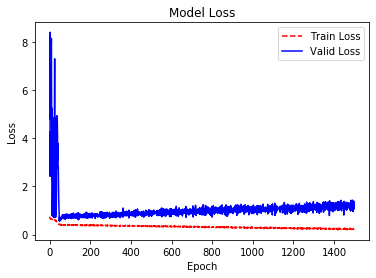

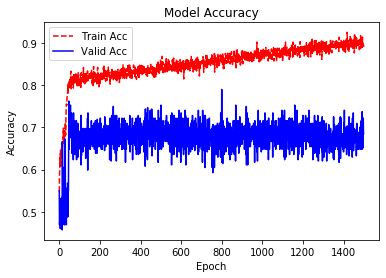

In [184]:
def plot_history(history):
    #   畫出訓練過程的損失度變化
    plt.plot(history.history['loss'],'r--')
    plt.plot(history.history['val_loss'],'b-')
    plt.title('Model Loss')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    LOss='data/Binary_{}_{}_loss.png'.format(one_v_all_label,datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
    plt.savefig(LOss)
    plt.show();
    #   畫出訓練過程的準確度變化
    plt.plot(history.history['acc'],'r--')
    plt.plot(history.history['val_acc'],'b-')
    plt.title('Model Accuracy')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    Acc='data/Binary_{}_{}_acc.png'.format(one_v_all_label,datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
    plt.savefig(Acc)
    plt.show()
# requires history=model.fit, fit_generator.
plot_history(history)

In [185]:
print(all_labels)
# 測試集分批步數
# 90/16=5.625
steps = test_generator.samples/batch_size
# 宣告每一個有2個結果並以0為預設，preds為預測結果，y_test為實際類別
preds = np.zeros((0,2))
# print(preds)
y_test = np.zeros((0,2))
# batch_x影像陣列，batch_y影像類別
# for i=0,i<10,i++
step_count = 0
for batch_x, batch_y in test_generator:
#     predict每次預測一張影像
    batch_preds = model.predict(batch_x)
#     vstackt垂直整合結果
    preds = np.vstack((preds,batch_preds))
    y_test = np.vstack((y_test,batch_y))
    step_count = step_count + 1
#     >5.625
    if step_count > steps:
        break
# print(len(y_test))
# print(y_test)

['0', '1']


In [186]:
preds.flatten()

array([8.70027900e-01, 1.32191762e-01, 9.87203300e-01, 1.39103690e-02,
       9.30052757e-01, 8.25098380e-02, 9.93078887e-01, 6.98799780e-03,
       9.76969421e-01, 2.39785798e-02, 3.13093573e-01, 7.11766303e-01,
       1.00487098e-03, 9.99083519e-01, 3.30616385e-02, 9.70002830e-01,
       9.33841050e-01, 6.92604631e-02, 3.42076411e-03, 9.96156156e-01,
       5.14303386e-01, 4.90909815e-01, 2.51467258e-01, 7.42509961e-01,
       4.41038102e-01, 5.63959777e-01, 1.67049006e-01, 8.35587442e-01,
       3.11519235e-01, 6.85896099e-01, 3.50368097e-02, 9.62221205e-01,
       1.59101889e-01, 8.40165555e-01, 4.34806645e-01, 5.83019733e-01,
       2.02004425e-02, 9.81152415e-01, 9.87954140e-01, 1.05928089e-02,
       9.90226209e-01, 9.39405896e-03, 6.09770775e-01, 3.56762737e-01,
       9.58788872e-01, 4.25062478e-02, 9.88325715e-01, 1.20513430e-02,
       8.84414434e-01, 1.33468956e-01, 9.57800448e-01, 4.25068215e-02,
       8.45594332e-03, 9.90416050e-01, 9.99998927e-01, 1.41924568e-06,
      

auc: 0.7645938119189148
auc 0.7645938119189148


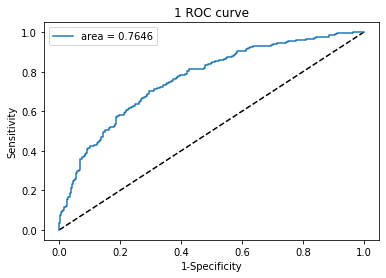

In [189]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
# flatten()攤平結果
# 計算AUROC分數
auroc = roc_auc_score(y_test.flatten(), preds.flatten())
print('auc:',auroc)
# 取得fpr(偽陽性率)、tpr(真陽性率)和thresholds(閾值)。
fpr, tpr, thresholds = roc_curve(y_test.flatten(), preds.flatten())
# 計算AUROC分數
auc = auc(fpr, tpr)
print('auc',auc)
# 宣告新圖
plt.figure(1)
# 數值範圍
plt.plot([0, 1], [0, 1], 'k--')
# 曲線
plt.plot(fpr, tpr, label='area = {:.4f}'.format(auc))
plt.xlabel('1-Specificity') # False positive rate
plt.ylabel('Sensitivity') # True positive rate
plt.title('{} ROC curve'.format(one_v_all_label))
# 顯示AUROC分數
plt.legend(loc='best')
# 儲存
rocfig='data/Binary_{}_{}_roc.png'.format(one_v_all_label,datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
# plt.savefig(rocfig)
plt.show()

In [190]:
# 取得實際類別最大值，如y=[1,0] → y=0；y=[0,1] → y=1
y_trues = [np.argmax(ii) for ii in y_test]
print('y_trues\n',y_trues)
# 取得預測結果最大值，如y=[0.91,0.25] → y=0；y=[0.12,0.92] → y=1
y_preds = [np.argmax(ii) for ii in preds]  
print('y_preds\n',y_preds)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.metrics import confusion_matrix
# [[tn, fp]
#  [fn, tp]]
cm=confusion_matrix(y_trues, y_preds)
tn,fp,fn,tp=cm.ravel()

print(cm)
print('Accuracy: ', (tn+tp)/(tn+fp+fn+tp))
print('Sensitivity: ', tp/(fn+tp))
print('Specificity: ', tn/(tn+fp))

y_trues
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y_preds
 [0, 0, 0,

<Figure size 432x288 with 0 Axes>

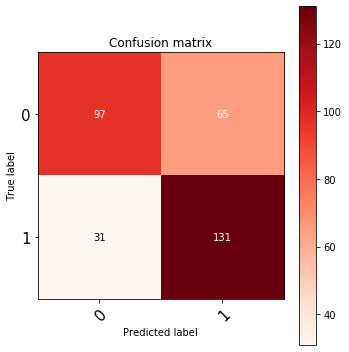

In [191]:
# cm混淆矩陣，classes類別，cmap=plt.cm.Blues藍色
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Reds):
#     宣告新圖
    plt.figure()
    title = 'Confusion matrix'
    # 宣告fig圖，ax內容
    fig, ax = plt.subplots(1,1, figsize = (5,5))
    # 顯示為圖片
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # 設定顏色
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),#     表格格數
           yticks=np.arange(cm.shape[0]),#     表格格數
           # ... and label them with the respective list entries
           xticklabels=classes, 
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    # rotationv旋轉角度，ha文字水平對齊，rotation_mode圍繞對齊點進行旋轉，fontsize文字大小
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize = 15)
    plt.setp(ax.get_yticklabels(), fontsize = 15)

    thresh = cm.max() / 3.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # d->整數，f->float
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", fontsize = 10, color="white" if cm[i, j] > thresh else "black")
    # 避免圖、文字重疊，使用tight_layout分開
    fig.tight_layout()
    # y軸寬度
    plt.ylim(len(np.unique(classes))-0.5, -0.5)
    
    conmatrix='data/Binary_{}_{}_cm.png'.format(one_v_all_label,datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
#     plt.savefig(conmatrix)
    plt.show()
    
plot_confusion_matrix(cm,classes=all_labels)

In [192]:
from sklearn.metrics import classification_report
import pandas as pd
# classification_report(真實類別，預測類別，類別)
print(classification_report(y_trues, y_preds, target_names = all_labels))
# output_dict=True轉成字典格式回傳
report = classification_report(y_trues, y_preds, target_names = all_labels, output_dict=True)
# print(report)
# transpose轉成表格模式
df = pd.DataFrame(report).transpose()
print('df\n',df)
reportname='data/Binary_{}_{}_report.csv'.format(one_v_all_label,datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
# df.to_csv(reportname)

              precision    recall  f1-score   support

           0       0.76      0.60      0.67       162
           1       0.67      0.81      0.73       162

    accuracy                           0.70       324
   macro avg       0.71      0.70      0.70       324
weighted avg       0.71      0.70      0.70       324

df
               precision    recall  f1-score     support
0              0.757812  0.598765  0.668966  162.000000
1              0.668367  0.808642  0.731844  162.000000
accuracy       0.703704  0.703704  0.703704    0.703704
macro avg      0.713090  0.703704  0.700405  324.000000
weighted avg   0.713090  0.703704  0.700405  324.000000
